In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('classic')

import seaborn as sns

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
data= pd.read_csv('/data/Good data storage.csv')
data.head()

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
0,2016072704,27,3,0,0,0,1,"26,27,28,29","31,32,33,34,35",1,0,NaN,50Hz IE preonly
1,2017021501,30,3,0,0,0,2,"12,13","16,17",1,0,NaN,50Hz IE preonly
2,2016091403,30,2,0,0,0,1,"14,15","17,18",1,1,NaN,50Hz IE preonly
3,2017062202,24,1,0,0,0,1,"30,31,32","34,35",1,0,"No change, good data",50Hz IE preonly
4,2016072902,29,1,0,1,0,0,43,"45,46,47,48,49",1,0,NaN,50Hz IE preonly


In [3]:
data_pre_50Hz_reci = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==1)]
data_pre_50Hz_uni = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==0)]

In [4]:
data_pre_50Hz_reci

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
12,2016092903,29,2,1,1,0,1,"4,5","7,8",2,0,NaN,50Hz EI preonly
14,2016091201,28,2,1,1,0,1,"16,17,18","21,22,23,24,25",2,13,NaN,50Hz EI preonly
15,2016100201,26,1,1,1,0,2,"3,4","6,7,8",2,0,NaN,50Hz EI preonly
16,2016100303,27,1,1,1,0,2,"4,5","8,9,10,11,12",2,7,Increased PPR,50Hz EI preonly
17,2016100304,27,2,1,1,0,2,11,"13,14,15,16",2,4,"Reduced onset tau, incrased decay tau",50Hz EI preonly
18,2017021302,30,1,1,1,0,2,5,"7,8,9,10",2,0,Increased onset tau,50Hz EI preonly


In [5]:
data_pre_50Hz_uni

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
9,2016081002,27,1,1,0,0,0,1,"4,5,6",2,0,NaN,50Hz EI preonly
10,2016081703,26,2,1,0,0,1,"14,15,16,17","20,21,22,23",2,0,NaN,50Hz EI preonly
11,2016081002,28,1,1,0,0,0,1,"4,5,6,7,8",2,0,Reduced PPR,50Hz EI preonly
13,2016101201,30,2,1,0,0,2,"9,10","12,13,14,15",2,4,Reduced PPR,50Hz EI preonly
19,2017053101,34,2,1,0,1,1,"5,6","8,9",2,18,NaN,50Hz EI preonly
20,2017051501,32,1,1,0,0,1,7,"9,10",2,0,NaN,50Hz EI preonly


<Container object of 3 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


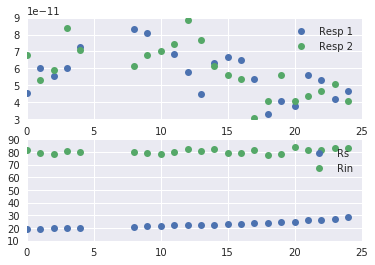

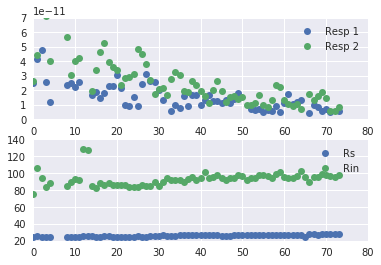

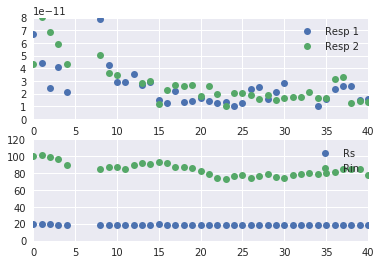

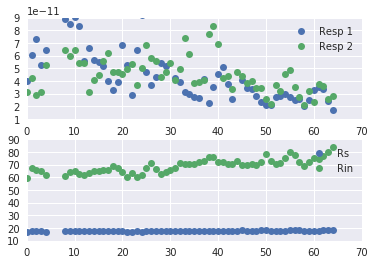

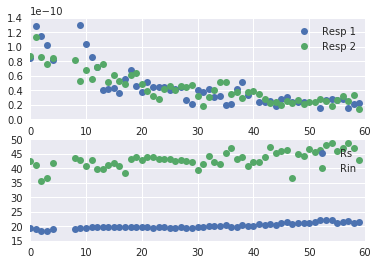

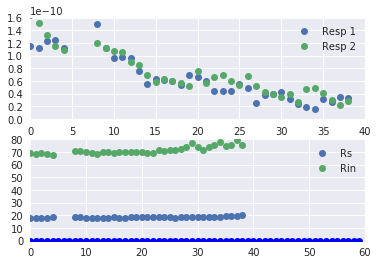

In [6]:
# patch_pip.df_ana(data_pre_50Hz_reci,'/data/data_pre_50Hz_reci', end_ana=[20,60,35,60,50,35])
patch_pip.df_ana(data_pre_50Hz_reci,'/data/data_pre_50Hz_reci')
pre_50Hz_reci = pd.read_pickle('/data/data_pre_50Hz_reci')
ave_ptl_mean, ave_ptl_ste = patch_pip.sample_plot(pre_50Hz_reci)
plt.errorbar(x=np.arange(len(ave_ptl_mean)), y=ave_ptl_mean, yerr=ave_ptl_ste, fmt='bo')

In [7]:
pre_50Hz_reci['Before'].index

Int64Index([12, 14, 15, 16, 17, 18], dtype='int64')

(0, 2e-10)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


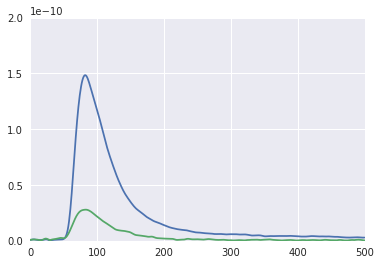

In [8]:
sample_id = 18
plt.plot(np.nanmean(np.vstack(pre_50Hz_reci['Before'].loc[sample_id]['trace_y1'])[:, :500], axis=0))
plt.plot(np.nanmean(np.vstack(pre_50Hz_reci['After'].loc[sample_id]['trace_y1'])[-5:,:500], axis=0))
plt.ylim([0, 2e-10])
# with PdfPages('/data/Figure1A_3.pdf') as pdf:
#     pdf.savefig()

In [9]:
elimi = np.array([20,60,35,60,50,35])
elimi_sr = pd.Series(elimi, index=pre_50Hz_reci.index)
pre_50Hz_reci['elimi']=elimi_sr
pre_50Hz_reci.to_pickle('/data/ana_pre_50Hz_reci')

/src/Patch_ana/Patch_ana/patch_pip.py:363: RuntimeWarning: Mean of empty slice
  output['onset_tau'] = np.nanmean(onset_tau)
/src/Patch_ana/Patch_ana/patch_pip.py:364: RuntimeWarning: Mean of empty slice
  output['decay_tau'] = np.nanmean(decay_tau)


<Container object of 3 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


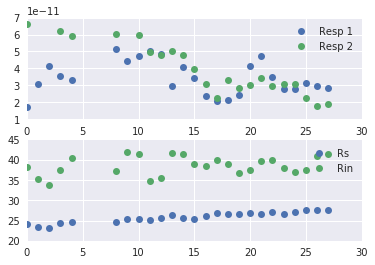

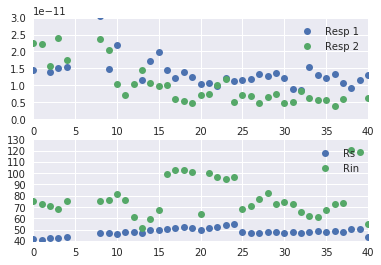

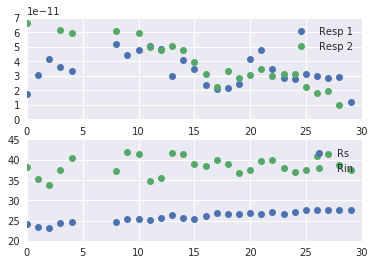

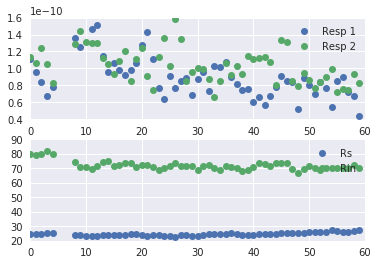

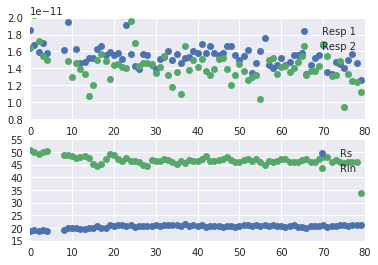

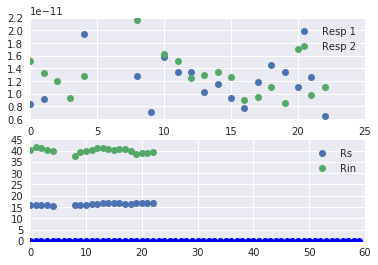

In [10]:
patch_pip.df_ana(data_pre_50Hz_uni,'/data/data_pre_50Hz_uni')
pre_50Hz_uni = pd.read_pickle('/data/data_pre_50Hz_uni')
ave_ptl_mean, ave_ptl_ste = patch_pip.sample_plot(pre_50Hz_uni)
plt.errorbar(x=np.arange(len(ave_ptl_mean)), y=ave_ptl_mean, yerr=ave_ptl_ste, fmt='bo')

In [11]:
elimi = np.array([27,40,28,17,50,22])
elimi_sr = pd.Series(elimi, index=pre_50Hz_uni.index)
pre_50Hz_uni['elimi']=elimi_sr
pre_50Hz_uni.to_pickle('/data/ana_pre_50Hz_uni')